In [57]:
import itertools
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import sys
sys.path.append('../Environments/')
from ColoredGridWorld.MDP import MDP
from ColoredGridWorld import SetUpInferenceSpace as setUp
from ColoredGridWorld import visualizations
from ColoredGridWorld import OBMDP
sys.path.append('../Algorithms/')
from ActionInterpretation import ActionInterpretation
from ValueIteration import ValueIteration
import pprint

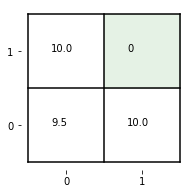

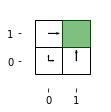

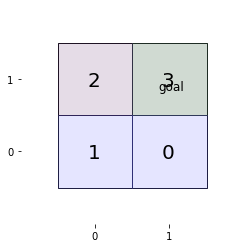

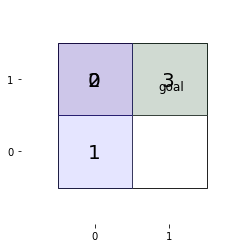

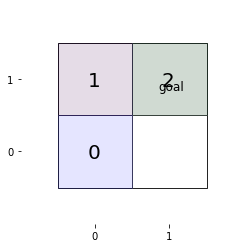

state: (0, 0)({'orange': 0, 'white': 0, 'yellow': 10}, (1, 1)) :0, {'orange': -2, 'white': 0, 'yellow': 10}, (1, 1)) :1)
	action: (0, 1)
		probability: 0.48746444804193245
	action: (0, -1)
		probability: 0.012535551958067541
	action: (1, 0)
		probability: 0.48746444804193245
	action: (-1, 0)
		probability: 0.012535551958067541
state: (0, 0)({'orange': 0, 'white': 0, 'yellow': 10}, (1, 1)) :0.25, {'orange': -2, 'white': 0, 'yellow': 10}, (1, 1)) :0.75)
	action: (0, 1)
		probability: 0.9624999213411861
	action: (0, -1)
		probability: 0.012500039329405072
	action: (1, 0)
		probability: 0.01250000000000381
	action: (-1, 0)
		probability: 0.012500039329405072
state: (0, 0)({'orange': 0, 'white': 0, 'yellow': 10}, (1, 1)) :0.5, {'orange': -2, 'white': 0, 'yellow': 10}, (1, 1)) :0.5)
	action: (0, 1)
		probability: 0.9624990417404036
	action: (0, -1)
		probability: 0.012500479129796144
	action: (1, 0)
		probability: 0.01250000000000381
	action: (-1, 0)
		probability: 0.012500479129796144
state

In [65]:
"""
    function to get the trajectory in case of communicative demonstrations
    input: initialState, policyTable, object-level goal State, jointTransitionFunction
    output: list of object level states
"""
def getJointTrajectory(jointState, policyTable, goal, jointTransitionFn):
    traj = [jointState[0]]
    while(jointState[0]!=goal):
        action = max(policyTable[jointState], key=policyTable[jointState].get)
        jointState = max(jointTransitionFn(jointState, action), key = jointTransitionFn(jointState, action).get)
        traj.append(jointState[0])
    return traj
        
       
def viewPolicyStructure(d, levels, indent=0):
    for key, value in d.items():
        if (indent==0):
            beliefDict = key[1]()
            strkey = "("
            for env, prob in beliefDict.items():
                strkey = strkey + str(env[0]()) + ", " + str(env[1]) + ") :" + str(prob) + ", "
            strkey = strkey[:len(strkey)-2] + strkey[len(strkey):]
            strkey = strkey + ")"
            print('\t' * indent + str(levels[indent]) + ": "+ str(key[0]) + strkey)
        else: 
            print('\t' * indent + str(levels[indent]) + ": "+ str(key))
        if isinstance(value, dict):
            viewPolicyStructure(value, levels, indent+1)
        else:
            print('\t' * (indent+1) + str(levels[indent+1])+ ": " + str(value))

def main():
    #set up for object-level MDP
    dimensions = (2,2)
    goalState = (1,1)
    goals = [(1,1)]
    actions = {(-1,0),(0,1),(0,-1),(1,0)}
    goalNameDictionary = {(1,1):'goal'}
    colourReward = {'white': 0, 'orange': 0, 'yellow':10}
    stateSpace = {(0,0): 'white',(0,1): 'orange',(1,0): 'white',(1,1): 'yellow'}
    getMDP = MDP(dimensions, stateSpace, colourReward)
    rewardFunction, transitionPdf = getMDP()
    
    #set up for value-iteration and inference
    convergenceTolerance = 10e-7
    gamma = .95
    alpha = 20
    eps = 0.05
    hyperparameters = (convergenceTolerance, gamma, alpha, eps)
    
    variableColours = ['orange']
    variableReward = [0, -2]
    constantRewardDict = {'white': 0, 'yellow': 10}
    utilitySpace = setUp.buildUtilitySpace(variableColours, variableReward, constantRewardDict)
    transitionSpace = [True]
    worlds = setUp.buildWorldSpace(utilitySpace, transitionSpace)
    envSpace = [(world, goal) for world, goal in product(worlds, goals)]
    envMDPsAndPolicies = setUp.buildEnvPolicySpace(dimensions, stateSpace, actions, envSpace, hyperparameters)
    actionInterpretation = ActionInterpretation(envMDPsAndPolicies)
    
    #set up for OBMDP and its value iteration 
    beta = 10
    beliefGamma = 0.95
    beliefAlpha = 20
    beliefEps = 0.05
    bins = [0,0.25,0.5,0.75,1]
    beliefSpacePossible = [{key:value for key, value in zip(envSpace, permutations)} for permutations in product(bins, repeat = len(envSpace))]
    discreteBeliefSpace = [beliefDict for beliefDict in beliefSpacePossible if (sum(value for value in beliefDict.values())==1)]
    hashableDiscreteBeliefSpace = [setUp.HashableBelief(beliefDict) for beliefDict in discreteBeliefSpace]
    beliefUtilityFn = OBMDP.getBeliefUtility()
    literalObserver = OBMDP.LiteralObserverIndicator(actionInterpretation)
    literalObserverFn = literalObserver(discreteBeliefSpace, True)
    jointStateSpace = list(product(stateSpace.keys(), hashableDiscreteBeliefSpace))
    getOBMDP = OBMDP.OBMDP(jointStateSpace, (setUp.HashableWorld(colourReward, True), goals[0]), True, beta)
    jointRewardFn, jointTransitionFn = getOBMDP(transitionPdf, rewardFunction, literalObserverFn, beliefUtilityFn)
    
    #implementing object-level MDP
    valueTable = {key: 0 for key in stateSpace.keys()}
    performValueIteration = ValueIteration(actions, transitionPdf, rewardFunction, valueTable, [goalState], convergenceTolerance, gamma, alpha, eps, True)
    optimalValues, policyTable = performValueIteration()
    trapStates = [s for s in stateSpace if(colourReward[stateSpace[s]]<0)]
    m,n = dimensions
    visualizations.visualizeValueTable(m, n, goalState, trapStates, optimalValues)
    visualizations.visualizePolicy(stateSpace, policyTable, goalState, otherGoals=[], trapStates=[], arrowScale = .3)
    
    #implementing OBMDP
    valueTable = {key: 0 for key in jointStateSpace}
    jointGoalStates = [jointState for jointState in jointStateSpace if jointState[0] == goals[0]]
    performValueIteration = ValueIteration(actions, jointTransitionFn, jointRewardFn, valueTable, jointGoalStates, convergenceTolerance, beliefGamma, beliefAlpha, beliefEps, True)
    optimalValues, policyTable = performValueIteration()
    initialState1 = ((1,0), setUp.HashableBelief( { (setUp.HashableWorld({'orange':0, 'white':0, 'yellow':10}, True),(1,1)): 0.25, (setUp.HashableWorld({'orange':-2, 'white':0, 'yellow':10}, True),(1,1)): 0.75 }) )
    initialState2 = ((0,1), setUp.HashableBelief( { (setUp.HashableWorld({'orange':0, 'white':0, 'yellow':10}, True),(1,1)): 0.25, (setUp.HashableWorld({'orange':-2, 'white':0, 'yellow':10}, True),(1,1)): 0.75 }) )
    initialState3 = ((0,0), setUp.HashableBelief( { (setUp.HashableWorld({'orange':0, 'white':0, 'yellow':10}, True),(1,1)): 0.25, (setUp.HashableWorld({'orange':-2, 'white':0, 'yellow':10}, True),(1,1)): 0.75 }) )
    trajectory1 = getJointTrajectory(initialState1, policyTable, goalState, jointTransitionFn)
    trajectory2 = getJointTrajectory(initialState2, policyTable, goalState, jointTransitionFn)
    trajectory3 = getJointTrajectory(initialState3, policyTable, goalState, jointTransitionFn)
    visualizations.visualizeEnvironmentByState(stateSpace, [goalState], [], trajectory1, goalNameDictionary, 4)
    visualizations.visualizeEnvironmentByState(stateSpace, [goalState], [], trajectory2, goalNameDictionary, 4)
    visualizations.visualizeEnvironmentByState(stateSpace, [goalState], [], trajectory3, goalNameDictionary, 4)
    viewPolicyStructure(policyTable, ["state", "action", "probability"])

    
if __name__ == "__main__":
    main()


